# Classification for the Spotify dataset
In the following, we will perform classification for the given dataset. Goal is _create a model classificator for labelling tracks by `genre`_.  
We will perform 3 attempts for this classification:
- multiclass classification with n_class = n_genra;
- multiclass classification with n_class < n_genra, and in particular we want to regroup consider some sort of 'basic' genra criterion. It has been considered the following classification: https://en.wikipedia.org/wiki/List_of_music_genres_and_styles;
- binary classification, not musical tracks vs musical tracks. 

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [83]:
from sklearn.model_selection import cross_val_score

## Evaluation metrics
Importing the metrics for evaluating performances.  
Here reporting some formulas in order to recap everything:  
$$Acc = \frac{TP + TN}{TP + TN + FP + FN} $$  
The F1 score can be interpreted as a harmonic mean (harmonic mean is the reciprocal of the aritmetic mean of the reciprocals. It is sometimes appropriate for situations when the average rate is desired) of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is F1 = 2 * (precision * recall) / (precision + recall):

$$F1_{\text{score}} = \frac{2TP}{2TP + FN + FP} $$  
$$Recall = \frac{TP}{TP + FN} $$

In [84]:
#Importing the performance metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [85]:
# importing datasets - one will be used for training, one for testing.
df_original_copy_training = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True)
df_train = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

df_test = pd.read_csv("dataset (missing + split)/test.csv", skipinitialspace=True)

# Data preparation: transformation and preprocessing
This has to be done on both training set and test set. 

### Data transformation

In [86]:
#Changing udm to duration_ms and features_duration_ms from ms to min - train
df_train['duration_ms'] *= 1/6e4
#Changing udm to duration_ms and features_duration_ms from ms to min - test
df_test['duration_ms'] *= 1/6e4
#Setting popularity as a % - train
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)
#Setting popularity as a % - test
df_test['popularity'] /= 100
df_test.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_test.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

### Filling of NaN values

In [87]:
#Dealing with mode attribute missing values - train
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
list_of_nan_indexes_train=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_train:
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0
        
#Dealing with mode attribute missing values - test
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_test['mode'].value_counts()[0]/(len(df_test)-df_test['mode'].isnull().sum())
p1=df_test['mode'].value_counts()[1]/(len(df_test)-df_test['mode'].isnull().sum())
list_of_nan_indexes_test=df_test[df_test['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_test:
    if np.random.random() < p1:
        df_test.loc[i,'mode'] = 1.0
    else:
        df_test.loc[i,'mode'] = 0.0

In [88]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]
    
#Dealing with time_signature attribute missing values - test
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_test['time_signature'].value_counts())
p_array=np.array(df_test['time_signature'].value_counts().sort_index(ascending=True)/(len(df_test)-df_test['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_test[df_test['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_test.loc[i,'time_signature'] = dict_ts[index]

Let's check if everything is fine

In [89]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [90]:
df_test.isnull().sum()

name                        0
duration_min                0
explicit                    0
popularity_percent          0
artists                     0
album_name                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
features_duration_ms        0
time_signature              0
n_beats                     0
n_bars                      0
popularity_confidence    4279
processing                  0
genre                       0
dtype: int64

In [91]:
df_train['genre'].value_counts()

genre
j-dance          750
iranian          750
brazil           750
chicago-house    750
forro            750
idm              750
indian           750
study            750
disney           750
afrobeat         750
mandopop         750
techno           750
sleep            750
spanish          750
j-idol           750
industrial       750
happy            750
bluegrass        750
black-metal      750
breakbeat        750
Name: count, dtype: int64

In [92]:
df_test['genre'].value_counts()

genre
industrial       250
breakbeat        250
happy            250
afrobeat         250
study            250
black-metal      250
sleep            250
bluegrass        250
techno           250
brazil           250
j-dance          250
chicago-house    250
disney           250
iranian          250
mandopop         250
idm              250
spanish          250
j-idol           250
indian           250
forro            250
Name: count, dtype: int64

Pay attention, in train and test sets, genra does not have same order, it is necessary to use a dictionary map for BOTH. 

### Outlier criteria
For now, we do not consider any point as outlier because none of them miss the classification label and considering that this time one of our tasks is to distinguish between musical genra and not-musical genra. 

### Eliminating redundant features

In [93]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [94]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats'] 
df_train.drop(column2drop, axis=1, inplace=True)
df_test.drop(column2drop, axis=1, inplace=True)

### Encoding `str` values - creating the various `genre` maps
- first map: 20 classes, one for every genre;
- second map: regrouping per macro genre with the following labels:  

| Label | Macro genre | `genre` list |
| ----------- | ----------- | -----------------------------------------------|
| 0 | Electronic | `breakbeat`, `chicago house`, `techno`, `afrobeat`, `idm` |
| 1 | Asian |`indian`|
| 2 | Pop| `mandopop`,`j-idol`,`happy`,`disney`,`j-dance`|
| 3 | Latin | `forro`,`brazil`,`spanish`|
| 4 | Country | `bluegrass`|
| 5 | Metal | `black metal`|
| 6 | Iranian | `iranian`|
| 7 | Others | `sleep`, `study`|

In [95]:
#Creating genre map I -> mapping every genre into an int value in order to have correlation values. 
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
#Creating genre map II -> mapping in macro-categories as described above
macrogenre_map={"j-dance":2,"iranian":6,"brazil":3,"chicago-house":0,"forro":3,"idm":0,"indian":1,"study":7,"disney":2,"afrobeat":0,"mandopop":2,"techno":0,"sleep":7,"spanish":3,"j-idol":2,"industrial":0,"happy":2,"bluegrass":4,"black-metal":5,"breakbeat":0}

#aa

NB: here _partitioning_ is not necessary because both train and test sets are already equally partitioned (so,holdout is not performed).

## First `genre` map - all genra in a different category

In [15]:
df_train.replace({'genre':genre_map}, inplace=True)

In [16]:
df_test.replace({'genre':genre_map}, inplace=True)

### Encoding attributes

In [96]:
from sklearn.preprocessing import LabelEncoder

#### Encoding `explicit`

In [97]:
#just a trial, encoding the bool attribute `explicit`
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])
df_test['explicit'] = le.fit_transform(df_test['explicit'])

#### Dummy encoding of `key`, `time_signature`

In [98]:
df_train = pd.get_dummies(df_train, columns=['key', 'time_signature'], dtype=int)
df_test = pd.get_dummies(df_test, columns=['key', 'time_signature'], dtype=int)

In [99]:
#Saving a variable containing all non-classification attributes
attributes = [col for col in df_train.columns if col != 'genre']

#### Creating I dataset

In [21]:
y_train = df_train['genre']
y_test = df_test['genre']

In [22]:
X_train = df_train[attributes].values
X_test = df_test[attributes].values

In [23]:
X_train

array([[4.02933333, 0.        , 0.46      , ..., 0.        , 1.        ,
        0.        ],
       [7.4       , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [5.55843333, 0.        , 0.03      , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [6.66818333, 0.        , 0.43      , ..., 0.        , 1.        ,
        0.        ],
       [3.2875    , 0.        , 0.37      , ..., 0.        , 1.        ,
        0.        ],
       [3.30681667, 0.        , 0.36      , ..., 0.        , 1.        ,
        0.        ]])

In [24]:
print(y_train)

0         0
1         1
2        18
3        17
4        16
         ..
14995     5
14996    12
14997    11
14998    19
14999     6
Name: genre, Length: 15000, dtype: int64


In [25]:
print(X_train)

[[4.02933333 0.         0.46       ... 0.         1.         0.        ]
 [7.4        0.         0.         ... 0.         1.         0.        ]
 [5.55843333 0.         0.03       ... 0.         1.         0.        ]
 ...
 [6.66818333 0.         0.43       ... 0.         1.         0.        ]
 [3.2875     0.         0.37       ... 0.         1.         0.        ]
 [3.30681667 0.         0.36       ... 0.         1.         0.        ]]


# Decision tree - I map

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', 
#max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#class_weight=None, ccp_alpha=0.0)[source]

For now, we work only on _training test set_, in order to tune properly the parameters of the tree.  
After that, the test set will be used for computing the performance metrics. 

In [27]:
# Training a not-tuned tree, computing its performance metrics for doing a post-tuning comparison
dt = DecisionTreeClassifier()

In [28]:
%%time
dt.fit(X_train, y_train)

CPU times: user 206 ms, sys: 3.42 ms, total: 209 ms
Wall time: 207 ms


DecisionTreeClassifier()

#### Characteristics of the not-tuned tree

In [30]:
help(dt.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leave

In [31]:
dt.tree_.n_leaves

5109

That is, the mean cardinality of every leaf is 3, the tree is overfitting tremendously because there is no limit in its parameters. 

In [33]:
dt.tree_.max_depth

30

In [34]:
dt.tree_.node_count

10217

The tree splits 30 times and has 10217 nodes (2/3 of dataset).

In [35]:
y_train_pred = dt.predict(X_train)

In [36]:
y_train

0         0
1         1
2        18
3        17
4        16
         ..
14995     5
14996    12
14997    11
14998    19
14999     6
Name: genre, Length: 15000, dtype: int64

In [37]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [38]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750
           2       1.00      1.00      1.00       750
           3       1.00      1.00      1.00       750
           4       1.00      1.00      1.00       750
           5       1.00      1.00      1.00       750
           6       1.00      1.00      1.00       750
           7       1.00      1.00      1.00       750
           8       1.00      1.00      1.00       750
           9       1.00      1.00      1.00       750
          10       1.00      1.00      1.00       750
          11       1.00      1.00      1.00       750
          12       1.00      1.00      1.00       750
          13       1.00      1.00      1.00       750
          14       1.00      1.00      1.00       750
          15       1.00      1.00      1.00       750
          16       1.00      1.00      1.00       750
          17       1.00    

Okay, something seems wrong... let's keep going and try to understand what happened. 

In [39]:
print('Train Accuracy, no cross validation: %s' % accuracy_score(y_train, y_train_pred))
print('Train Accuracy, cross validation with 5 layers: %s' % cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy'))

Train Accuracy, no cross validation: 1.0
Train Accuracy, cross validation with 5 layers: [0.445      0.43133333 0.42933333 0.43733333 0.42033333]


#### What is happening:
It is evident the _overfitting_. The tree is computed considering the whole train test, being the tree overfitted, it gives perfect behaviour. When only a part of the training is used and the rest has to be predicted, the performances drastically worsen, because the model is adapted only to the training specific instances. 

In [40]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.1410654568898684
duration_min 0.10964068098899375
acousticness 0.09706925503662561
danceability 0.09692908826603089
loudness 0.08806090354429108
valence 0.08196205321765172
tempo 0.07044140741941289
speechiness 0.06721562284489714
instrumentalness 0.06721371534984463
energy 0.0646318576635997
liveness 0.046610028603533575
mode 0.008126444499831924
explicit 0.0059418175004360245
key_0 0.00568987661953832
key_2 0.0050336102289606464
key_9 0.004896687177598701
key_6 0.004714623172743417
key_5 0.004473293989351135
key_7 0.004360225110399747
key_8 0.004074510480260745
key_1 0.0038804779138102243
time_signature_4.0 0.0036453188359425346
key_11 0.0034780603008762925
key_10 0.0027539573803622443
key_4 0.0027040395558110635
time_signature_3.0 0.002374163402036589
key_3 0.0015596480499580757
time_signature_5.0 0.0008639757902915803
time_signature_1.0 0.0002949253110333556
time_signature_0.0 0.0002942748560081368


The tree is using all features of data objects, it seems reasonable in an overfitting situation; let's see what happens after tuning. 

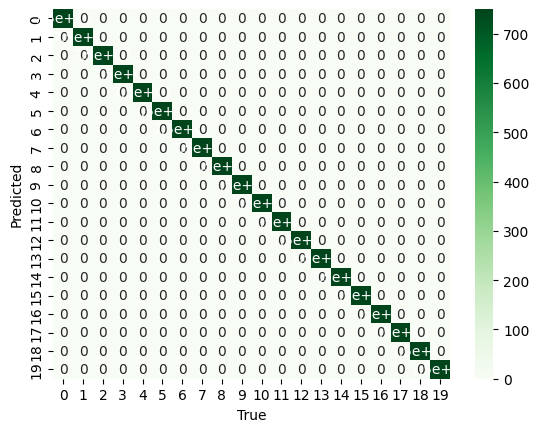

In [41]:
cf = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

### Parameter tuning - I map
#### Randomized Search
See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
Here the difference between this an `GridSearchCV()`:   
"_In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by $n_{iter}$._"

In [42]:
# For metric choice with cross_val_score see: https://scikit-learn.org/0.15/modules/model_evaluation.html
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [43]:
scores = cross_val_score(dt, X_train, y_train, cv=5)
print(scores)

[0.43866667 0.42266667 0.43633333 0.435      0.43366667]


Another confirm of overfitting, when dataset is splitted into train and validation, the performances drastically drop, pointing out that the tree formed is just adapting to data, not classifying.

Before exploring a randomized search, we want to have an idea of what kind of values are reasonable for the most interesting parameters of the tree. 

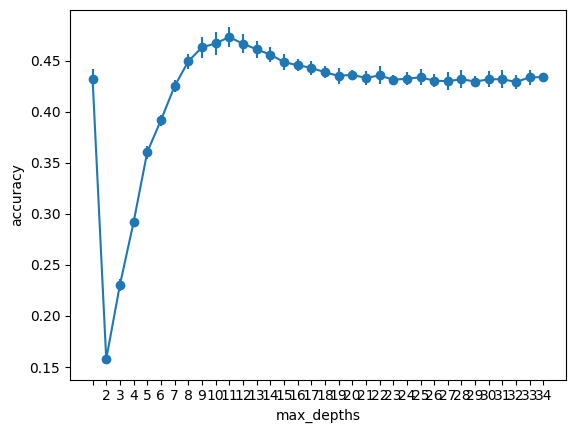

In [44]:
# considering max_depth
max_depths = [None] + list(np.arange(2, 35))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

Best `max_depth` alone seems 10, but let's see other parameters and then let's do the random search.

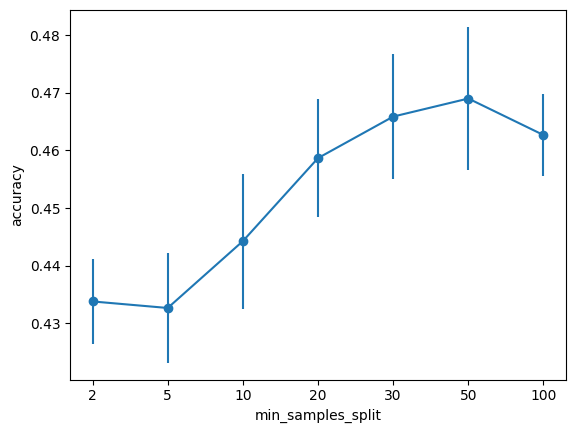

In [45]:
# considering min_samples_split
min_samples_splits = list([2, 5, 10, 20, 30, 50, 100])
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

In [46]:
%%time
#Evaluating on a grid in order to find the best combination
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
    'criterion': ['gini', 'entropy']
}

#param_distributions : dict or list of dicts
#Dictionary with parameters names (str) as keys and distributions or 
#lists of parameters to try. Distributions must provide a rvs method 
#for sampling (such as those from scipy.stats.distributions). 
#If a list is given, it is sampled uniformly. If a list of dicts is given,
#first a dict is sampled uniformly, and then a parameter is sampled using that dict as above.

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

CPU times: user 7.76 s, sys: 2.31 s, total: 10.1 s
Wall time: 3min 43s


In [47]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 12, 'criterion': 'gini'} 0.47663999999999995


Let's see the shape parameters of the tuned tree.

In [48]:
clf.tree_.n_leaves


707

Okay, it is a big improvement! From >5000 to 707. 

In [52]:
clf.tree_.node_count

1413

In [51]:
clf.tree_.max_depth

12

The number of nodes is /10 (!!) and the max depth is less than the half. 

In [53]:
y_train_pred = clf.predict(X_train)

In [55]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       750
           1       0.72      0.78      0.75       750
           2       0.46      0.55      0.50       750
           3       0.67      0.69      0.68       750
           4       0.67      0.69      0.68       750
           5       0.58      0.45      0.51       750
           6       0.51      0.52      0.51       750
           7       0.74      0.88      0.80       750
           8       0.67      0.57      0.62       750
           9       0.47      0.44      0.46       750
          10       0.51      0.58      0.55       750
          11       0.63      0.53      0.58       750
          12       0.84      0.83      0.84       750
          13       0.49      0.41      0.45       750
          14       0.64      0.60      0.62       750
          15       0.51      0.52      0.51       750
          16       0.57      0.66      0.61       750
          17       0.61    

Those are reasonable, no longer overfitted by eye. Let's do the final tuning and then test and evaluate the final performances. 

In [57]:
#Printing feature importances for the optimized tree
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.21866800280269497
duration_min 0.12604954957245426
danceability 0.11736999507227791
acousticness 0.11275808321149279
loudness 0.08742090805866756
valence 0.0773767750675136
instrumentalness 0.07627481300830187
energy 0.056155243978076246
speechiness 0.05483953982907547
tempo 0.04954800183284386
liveness 0.01697908877213348
explicit 0.003969591760163693
mode 0.0012134426636368873
time_signature_5.0 0.0007782195623878184
time_signature_3.0 0.00042939973383221213
key_10 0.00014992559780271325
time_signature_4.0 1.9419476644649333e-05
key_0 0.0
key_1 0.0
key_2 0.0
key_3 0.0
key_4 0.0
key_5 0.0
key_6 0.0
key_7 0.0
key_8 0.0
key_9 0.0
key_11 0.0
time_signature_0.0 0.0
time_signature_1.0 0.0


Look... `key` and `time_signature` are not used. This seems weird, it is like said that key does not characterize `genre` at all.

In [58]:
#Saving the RandomSearchCV() results into a pandas dataframe.
#Note that the the search results in a score computed multiple 
#times that so has a statistic uncertainty. 
# n_iter is the parameter that sets how many times the measure 
# is computed. (default is 10)
results = pd.DataFrame(random_search.cv_results_)

In [59]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.123029,0.028551,0.001363,0.000954,20,20,8,gini,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.438667,...,0.439000,0.440667,0.447333,0.453000,0.453667,0.440667,0.441333,0.445093,0.009125,109
1,0.137990,0.024455,0.001051,0.000436,10,20,11,gini,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.462333,...,0.465333,0.477333,0.490667,0.475333,0.472333,0.470667,0.469333,0.472947,0.009345,9
2,0.121154,0.013501,0.001184,0.000714,10,50,13,gini,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.443667,...,0.451000,0.450333,0.455667,0.456667,0.449667,0.459667,0.460333,0.452940,0.009167,84
3,0.163876,0.024217,0.001348,0.000675,20,10,18,gini,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.465000,...,0.468333,0.467667,0.483333,0.470000,0.466000,0.472333,0.472000,0.471933,0.009250,20
4,0.116087,0.012647,0.001189,0.000759,5,1,8,gini,"{'min_samples_split': 5, 'min_samples_leaf': 1...",0.444333,...,0.445000,0.442000,0.443667,0.451000,0.450333,0.444333,0.445000,0.446020,0.008527,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.244660,0.047484,0.001055,0.000465,100,30,19,entropy,"{'min_samples_split': 100, 'min_samples_leaf':...",0.434333,...,0.468667,0.455000,0.444667,0.450667,0.455000,0.452667,0.474000,0.451833,0.011279,93
196,0.276041,0.040949,0.001232,0.000985,10,20,17,entropy,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.441333,...,0.472000,0.470333,0.460667,0.470667,0.468000,0.461333,0.474000,0.463253,0.010058,47
197,0.376449,0.047798,0.001503,0.000729,2,1,19,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 1...",0.409667,...,0.428667,0.433333,0.426667,0.426333,0.423000,0.417667,0.445333,0.429300,0.009452,129
198,0.374480,0.042126,0.001403,0.000783,2,1,17,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 1...",0.415000,...,0.427000,0.439333,0.432000,0.428000,0.424667,0.420333,0.448333,0.428853,0.009918,130


#### Notes on attributes of `random_search.cv_results_`
`rank_test_score` indicates the rank of a grid search parameter combination based on the `mean_test_score`.

<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

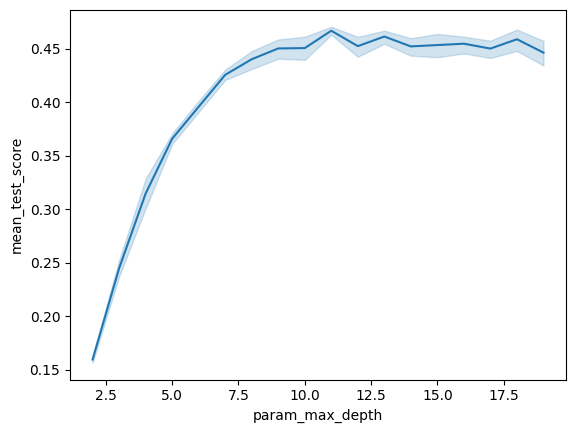

In [60]:
#max_depth : int, default=None
#The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure
#or until all leaves contain less than min_samples_split samples.

sns.lineplot(data=results, x="param_max_depth", y="mean_test_score")

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

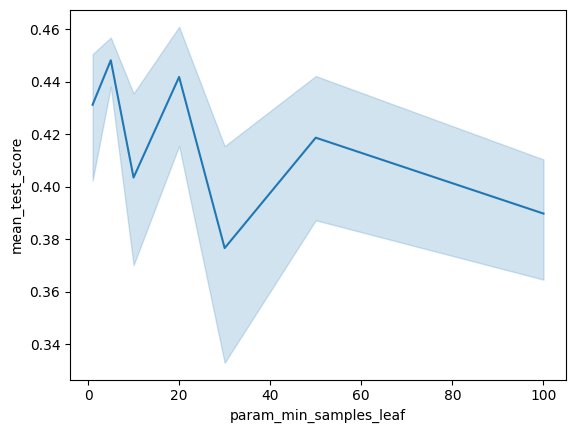

In [61]:
#min_samples_split : int or float, default=2
#The minimum number of samples required to split an internal node

sns.lineplot(data=results, x="param_min_samples_leaf", y="mean_test_score")

## Post-pruning and complexity evaluation

In [62]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

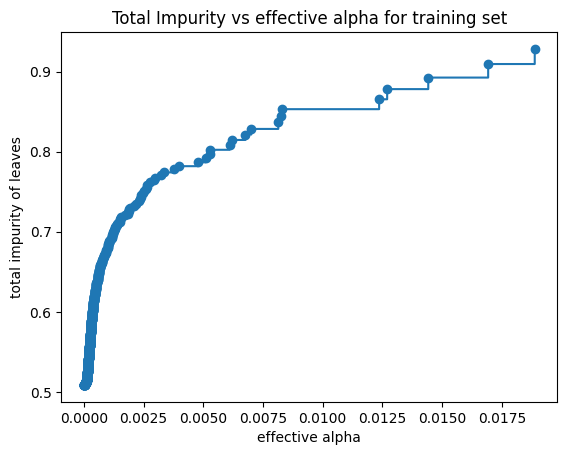

In [63]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [66]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    print( "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1])
)

Number of nodes in the last tree is: 1413 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1409 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1407 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1405 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1403 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1401 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1399 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1397 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1395 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1393 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1391 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1389 with ccp_alpha: 0.018877405040871875
Number of nodes in the last tree is: 1387 with ccp_a

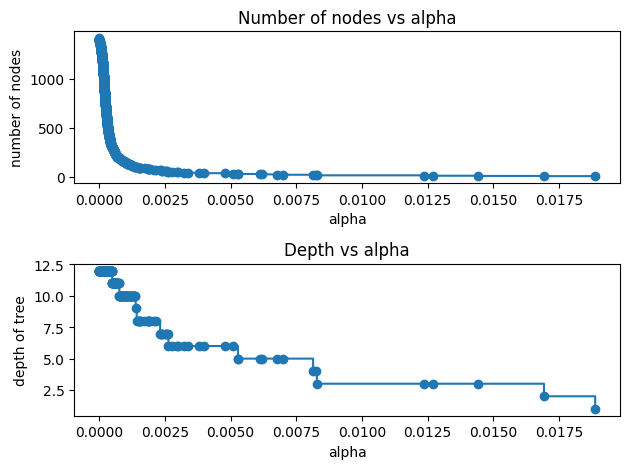

In [65]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Choosing `ccp_alpha` as the elbow point for those graphs (clearly, it is not a defined point, trade-offing by eye) so taking `ccp_alpha` = 0.0025 .

In [67]:
# Implementing the final-tuned tree
best_ccp_alpha = 0.0025
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha, **random_search.best_params_)

In [68]:
#Training the best-tuned tree
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0025, max_depth=12, min_samples_leaf=10,
                       min_samples_split=20, random_state=0)

#### Best tuned tree on training - performances and shape on training set

In [69]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       750
           1       0.72      0.78      0.75       750
           2       0.46      0.55      0.50       750
           3       0.67      0.69      0.68       750
           4       0.67      0.69      0.68       750
           5       0.58      0.45      0.51       750
           6       0.51      0.52      0.51       750
           7       0.74      0.88      0.80       750
           8       0.67      0.57      0.62       750
           9       0.47      0.44      0.46       750
          10       0.51      0.58      0.55       750
          11       0.63      0.53      0.58       750
          12       0.84      0.83      0.84       750
          13       0.49      0.41      0.45       750
          14       0.64      0.60      0.62       750
          15       0.51      0.52      0.51       750
          16       0.57      0.66      0.61       750
          17       0.61    

In [70]:
#Printing feature importances for the optimized tree
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.28106868249330524
danceability 0.17412841449934144
duration_min 0.13705822566882384
loudness 0.1119640589252034
instrumentalness 0.09368484274591705
acousticness 0.09018049809505582
speechiness 0.041113898618021616
valence 0.030697238178044633
energy 0.027220149463695744
tempo 0.012883991312591166
explicit 0.0
mode 0.0
liveness 0.0
key_0 0.0
key_1 0.0
key_2 0.0
key_3 0.0
key_4 0.0
key_5 0.0
key_6 0.0
key_7 0.0
key_8 0.0
key_9 0.0
key_10 0.0
key_11 0.0
time_signature_0.0 0.0
time_signature_1.0 0.0
time_signature_3.0 0.0
time_signature_4.0 0.0
time_signature_5.0 0.0


It is possible to see which are the real-used attributes for the tree classification, that are no longer all. 

In [71]:
print(f'Shapes of the tree: number of nodes = {clf.tree_.node_count}, number of leaf nodes = {clf.tree_.n_leaves}, maximum depth = {clf.tree_.max_depth}')

Shapes of the tree: number of nodes = 57, number of leaf nodes = 29, maximum depth = 7


## Evaluating final performances of the tree on test set for I `genre` map and finding the best `ccp_alpha`

Having found the decision tree with the best performances for the training test, for evaluating the 'real' performances, we use the decision tree for _predictions on test set_.

In [72]:
y_test_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.369


In [73]:
clf.score(X_test, y_test)

0.369

In [74]:
#Comparing train and test performances (with no cross validation)
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.6114666666666667
Train F1-score [0.61052632 0.7491982  0.50214329 0.67803279 0.68202765 0.50672646
 0.51187335 0.80487805 0.61904762 0.45867769 0.54511512 0.57864358
 0.83523874 0.44765343 0.61868512 0.51379763 0.61083744 0.62724936
 0.78954608 0.50345781]

Test Accuracy 0.369
Test F1-score [0.48625793 0.51941748 0.         0.5115304  0.45806452 0.24146982
 0.         0.66536965 0.29166667 0.         0.3280543  0.39719626
 0.70833333 0.18571429 0.46226415 0.         0.38184664 0.37440758
 0.5380531  0.22680412]


In [75]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.52      0.46      0.49       250
           1       0.66      0.43      0.52       250
           2       0.00      0.00      0.00       250
           3       0.54      0.49      0.51       250
           4       0.38      0.57      0.46       250
           5       0.35      0.18      0.24       250
           6       0.00      0.00      0.00       250
           7       0.65      0.68      0.67       250
           8       0.30      0.28      0.29       250
           9       0.00      0.00      0.00       250
          10       0.23      0.58      0.33       250
          11       0.48      0.34      0.40       250
          12       0.74      0.68      0.71       250
          13       0.14      0.26      0.19       250
          14       0.56      0.39      0.46       250
          15       0.00      0.00      0.00       250
          16       0.31      0.49      0.38       250
          17       0.27    

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


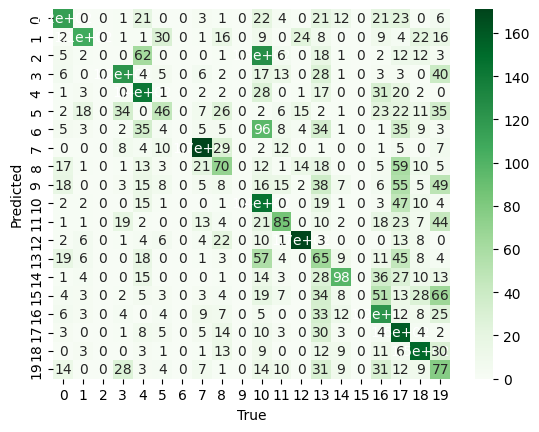

In [76]:
#Confusion matrix for test set
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

This first confusion matrix can help uderstanding the weak points. For example, genra `brazil` (number 2) and `industrial` (number 15), are never predicted, so always misclassified, some of them most of the times to another category, but sometimes distributed on more than one.  
`sleep` and `study` seems pretty well detected, this gives hope to find a good binary classificator. 

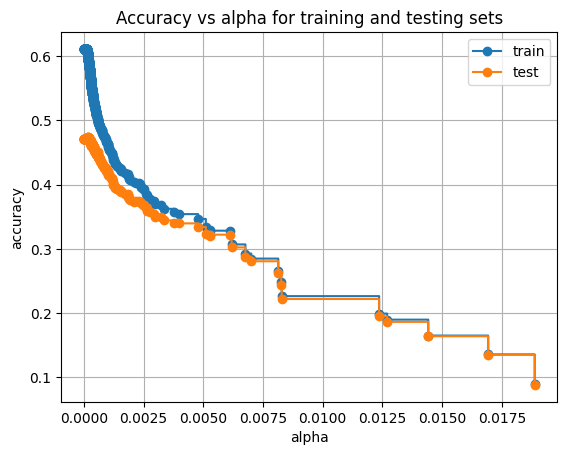

In [77]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.grid()
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In the first portion of the tree, where the pruning is not done or for just few branches, the overfitting is evident, because there is a big gap between performances of training and test set.  
We choose `ccp_alpha` that gives the best accuracy for the test set and a reasonably little gap between performances of the training test: `ccp_alpha`` = 0.0025$ as already chosen using the only train set, because of this, performances has been already evaluated.

In [79]:
print('Train Accuracy %s' % cross_val_score(dt, X_train, y_train))

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))

Train Accuracy [0.46066667 0.45066667 0.47266667 0.46566667 0.46366667]
Test Accuracy 0.369


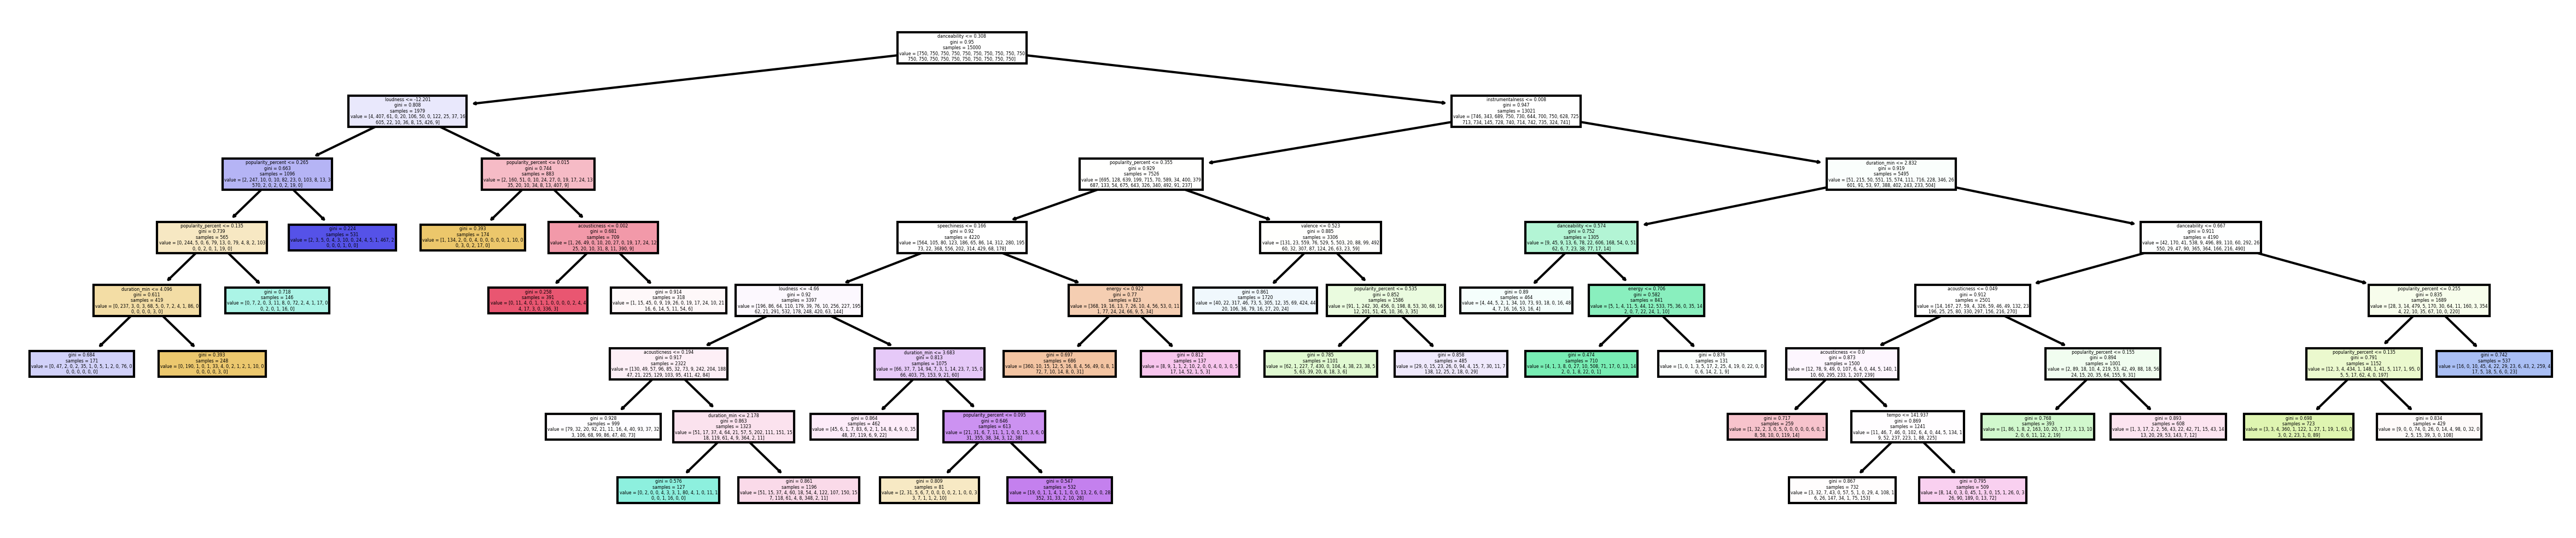

In [81]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=attributes, filled=True)
plt.show()

In [ ]:
#just for reference: 
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}

#### Creating II dataset

Note that here it is necessary to rerun superior cells in order to use the already-defined map for genra. 

In [100]:
y_train = df_train.replace({'genre':macrogenre_map})['genre']
y_test = df_test.replace({'genre':macrogenre_map})['genre']

X_train = np.array(df_train.replace({'genre':macrogenre_map})[attributes])
X_test = np.array(df_test.replace({'genre':macrogenre_map})[attributes])

# Decision tree - II map

In [105]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', 
#max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#class_weight=None, ccp_alpha=0.0)[source]

For now, we work only on _training test set_, in order to tune properly the parameters of the tree.  
After that, the test set will be used for computing the performance metrics. 

In [106]:
# Training a not-tuned tree, computing its performance metrics for doing a post-tuning comparison
dt = DecisionTreeClassifier()

In [107]:
%%time
dt.fit(X_train, y_train)

CPU times: user 180 ms, sys: 2.44 ms, total: 183 ms
Wall time: 181 ms


DecisionTreeClassifier()

In [109]:
dt.tree_.max_depth

29

In [110]:
dt.tree_.n_leaves

3530

Better than first case but really high... smells like overfitting. 

In [111]:
y_train_pred = dt.predict(X_train)

In [112]:
y_train


0        2
1        6
2        5
3        4
4        2
        ..
14995    0
14996    7
14997    0
14998    0
14999    1
Name: genre, Length: 15000, dtype: int64

In [113]:
y_train_pred

array([2, 6, 5, ..., 0, 0, 1])

In [114]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1. 1. 1. 1.]


In [115]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4500
           1       1.00      1.00      1.00       750
           2       1.00      1.00      1.00      3750
           3       1.00      1.00      1.00      2250
           4       1.00      1.00      1.00       750
           5       1.00      1.00      1.00       750
           6       1.00      1.00      1.00       750
           7       1.00      1.00      1.00      1500

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



There we are! Another overfitting. 

In [116]:
print('Train Accuracy, no cross validation: %s' % accuracy_score(y_train, y_train_pred))
print('Train Accuracy, cross validation with 5 layers: %s' % cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy'))

Train Accuracy, no cross validation: 1.0
Train Accuracy, cross validation with 5 layers: [0.56433333 0.58266667 0.577      0.573      0.56733333]


#### What is happening (again):
It is evident the _overfitting_. The tree is computed considering the whole train test, being the tree overfitted, it gives perfect behaviour. When only a part of the training is used and the rest has to be predicted, the performances drastically worsen, because the model is adapted only to the training specific instances. 

In [117]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity_percent 0.12763408161280135
instrumentalness 0.12749008260578545
danceability 0.11082922005382179
duration_min 0.10713046629044613
acousticness 0.09916727404084913
valence 0.06794184376859075
tempo 0.06663860466167071
loudness 0.06422878592973569
energy 0.06290491890788101
speechiness 0.0580519018483922
liveness 0.04748571027717615
key_0 0.006021352803125606
explicit 0.004841585640838863
mode 0.004708929296703081
key_11 0.004159701281957259
key_1 0.004067964884787315
key_9 0.0038144092553483266
time_signature_4.0 0.0037464917348744016
key_7 0.0036432159562558835
key_8 0.00358907336321311
key_6 0.0034420141069338894
key_2 0.0032197900129192483
key_4 0.003144684026803935
key_10 0.003098873373500494
time_signature_3.0 0.0028970624959705022
key_5 0.0025067560537096888
key_3 0.0016300147160949192
time_signature_5.0 0.0010327095644140076
time_signature_1.0 0.0008082578329148078
time_signature_0.0 0.0001242236024844721


As before, the tree is overfitting and so using all the attributes in order to adapt to data. 

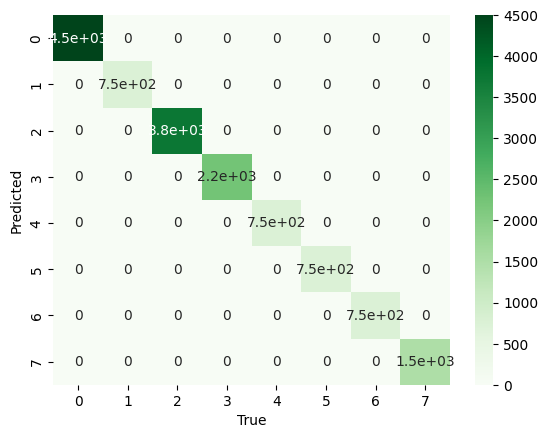

In [118]:
cf = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

### Parameter tuning - II map
#### Randomized Search
See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
Here the difference between this an `GridSearchCV()`:   
"_In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by $n_{iter}$._"

In [121]:
# considering max_depth
max_depths = [None] + list(np.arange(2, 30))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

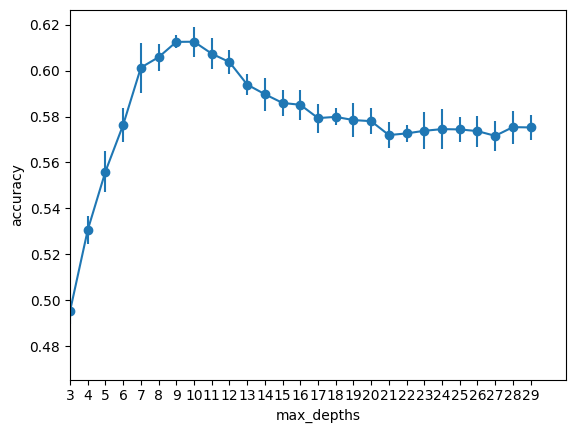

In [122]:
plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")

plt.xlim(2,30)
plt.show()

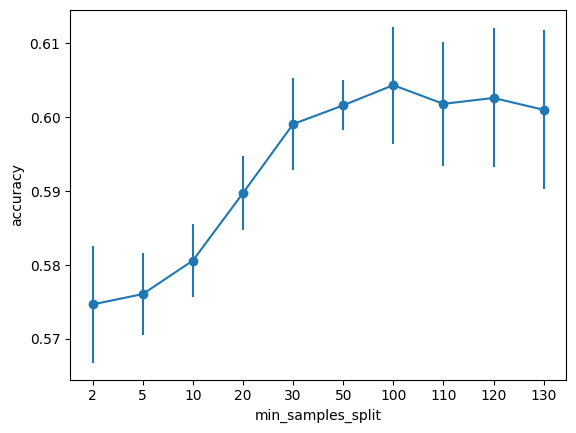

In [123]:
# considering min_samples_split
min_samples_splits = list([2, 5, 10, 20, 30, 50, 100, 110, 120, 130])
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

In [124]:
%%time
#Evaluating on a grid in order to find the best combination
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100, 150],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100, 150],
    'criterion': ['gini', 'entropy']
}

#param_distributions : dict or list of dicts
#Dictionary with parameters names (str) as keys and distributions or 
#lists of parameters to try. Distributions must provide a rvs method 
#for sampling (such as those from scipy.stats.distributions). 
#If a list is given, it is sampled uniformly. If a list of dicts is given,
#first a dict is sampled uniformly, and then a parameter is sampled using that dict as above.

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

CPU times: user 5.37 s, sys: 1.58 s, total: 6.95 s
Wall time: 2min 38s


In [125]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 11, 'criterion': 'entropy'} 0.6170399999999999


In [148]:
clf.tree_.n_leaves

238

Results are pretty different than the ones in the first map, Accuracy is almost doubled. 

In [126]:
#Printing feature importances for the optimized tree
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

instrumentalness 0.21982686631972345
popularity_percent 0.19134807308549598
acousticness 0.16364575530218617
danceability 0.13085266342692922
duration_min 0.08064026087395179
valence 0.05369027080778566
loudness 0.04821800937435447
tempo 0.037276746878538755
energy 0.03515103029037349
speechiness 0.02835191127115946
liveness 0.010998412369501602
explicit 0.0
mode 0.0
key_0 0.0
key_1 0.0
key_2 0.0
key_3 0.0
key_4 0.0
key_5 0.0
key_6 0.0
key_7 0.0
key_8 0.0
key_9 0.0
key_10 0.0
key_11 0.0
time_signature_0.0 0.0
time_signature_1.0 0.0
time_signature_3.0 0.0
time_signature_4.0 0.0
time_signature_5.0 0.0


There we are, seems better than before. 

In [127]:
#Saving the RandomSearchCV() results into a pandas dataframe.
#Note that the the search results in a score computed multiple 
#times that so has a statistic uncertainty. 
# n_iter is the parameter that sets how many times the measure 
# is computed. (default is 10)
results = pd.DataFrame(random_search.cv_results_)

In [128]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.165833,0.029989,0.001236,0.001196,150,50,11,entropy,"{'min_samples_split': 150, 'min_samples_leaf':...",0.589667,...,0.593000,0.597333,0.604000,0.593000,0.603333,0.607667,0.588667,0.596767,0.008117,93
1,0.125154,0.013569,0.001079,0.000662,150,1,17,gini,"{'min_samples_split': 150, 'min_samples_leaf':...",0.585667,...,0.600667,0.588667,0.588667,0.596000,0.595333,0.608000,0.579667,0.594453,0.007858,102
2,0.130236,0.012012,0.001216,0.000783,10,20,15,gini,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.601333,...,0.619333,0.604667,0.608667,0.603000,0.603000,0.629000,0.604667,0.608920,0.007955,36
3,0.109793,0.008965,0.000902,0.000414,150,30,None,gini,"{'min_samples_split': 150, 'min_samples_leaf':...",0.581000,...,0.600667,0.586667,0.586333,0.591667,0.592000,0.607000,0.577667,0.593513,0.007682,104
4,0.171566,0.015464,0.001281,0.000702,10,1,16,gini,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.578333,...,0.594333,0.584333,0.581333,0.588333,0.579667,0.583667,0.586333,0.585367,0.007464,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.095161,0.016483,0.001067,0.000509,10,100,18,gini,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.572000,...,0.589333,0.587667,0.579000,0.574000,0.577667,0.590667,0.565333,0.580227,0.007414,124
196,0.052742,0.012323,0.000872,0.000422,5,20,4,gini,"{'min_samples_split': 5, 'min_samples_leaf': 2...",0.524000,...,0.537000,0.538000,0.517000,0.535333,0.531667,0.533333,0.523000,0.527507,0.008133,169
197,0.092886,0.011472,0.001063,0.000521,50,100,15,gini,"{'min_samples_split': 50, 'min_samples_leaf': ...",0.572000,...,0.589333,0.587667,0.579000,0.574000,0.577667,0.590667,0.565333,0.580227,0.007414,124
198,0.116896,0.012245,0.001250,0.001141,20,20,10,gini,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.609667,...,0.622333,0.603667,0.605667,0.609000,0.604333,0.620667,0.603000,0.610220,0.007841,28


<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

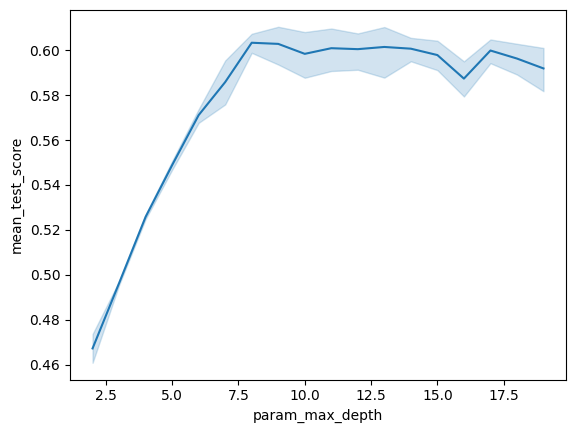

In [129]:
#max_depth : int, default=None
#The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure
#or until all leaves contain less than min_samples_split samples.

sns.lineplot(data=results, x="param_max_depth", y="mean_test_score")

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

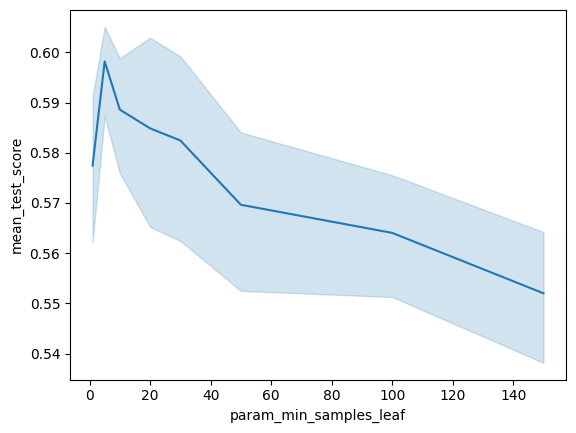

In [130]:
#min_samples_split : int or float, default=2
#The minimum number of samples required to split an internal node

sns.lineplot(data=results, x="param_min_samples_leaf", y="mean_test_score")

## Post-pruning and complexity evaluation - II map

In [131]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

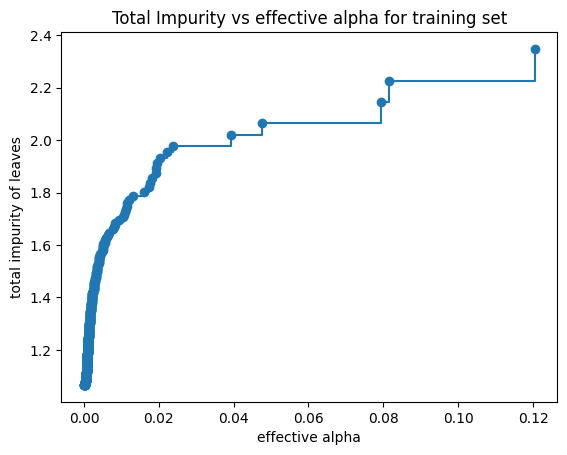

In [132]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [133]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.28064373182047264


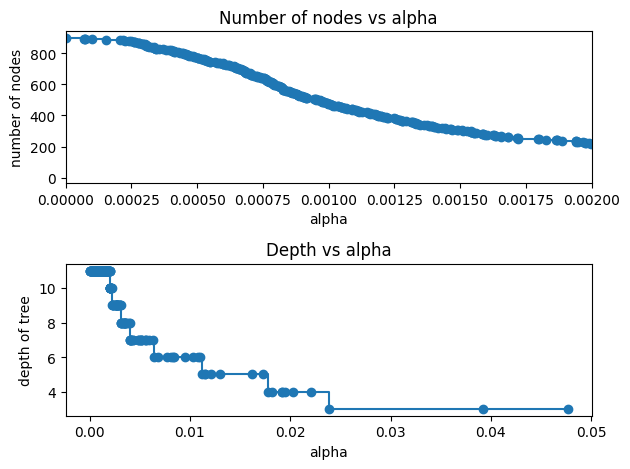

In [137]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[0].set_xlim(0,0.002)
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

For now, a good choice of `ccp_alpha` seems `ccp_alpha` = 0.01

In [144]:
best_ccp_alpha = 0.001
clf = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, **random_search.best_params_)

In [145]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=11,
                       min_samples_leaf=20, min_samples_split=20)

In [149]:
y_train_pred = clf.predict(X_train)

Having found the decision tree with the best performances for the training test, for evaluating the 'real' performances, we use the decision tree for _predictions on test set_. After comparing accuracy of test and train, we will confirm or change the value of `ccp_alpha` and compute the final performances. 

In [150]:
y_test_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.6126


In [151]:
#Comparing train and test performances (with no cross validation)
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.6759333333333334
Train F1-score [0.72685287 0.39294306 0.64310858 0.63034231 0.57250188 0.75189003
 0.68777707 0.79905756]

Test Accuracy 0.6126
Test F1-score [0.67925757 0.32786885 0.5762987  0.5510574  0.46436782 0.68789809
 0.64540338 0.73940678]


In [152]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1500
           1       0.40      0.28      0.33       250
           2       0.58      0.57      0.58      1250
           3       0.50      0.61      0.55       750
           4       0.55      0.40      0.46       250
           5       0.73      0.65      0.69       250
           6       0.61      0.69      0.65       250
           7       0.79      0.70      0.74       500

    accuracy                           0.61      5000
   macro avg       0.60      0.57      0.58      5000
weighted avg       0.61      0.61      0.61      5000



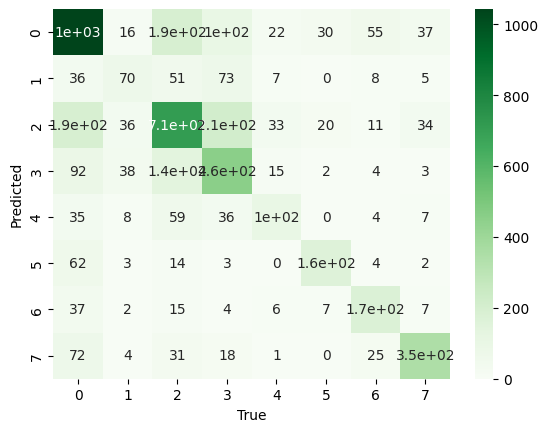

In [153]:
#Confusion matrix for test set
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

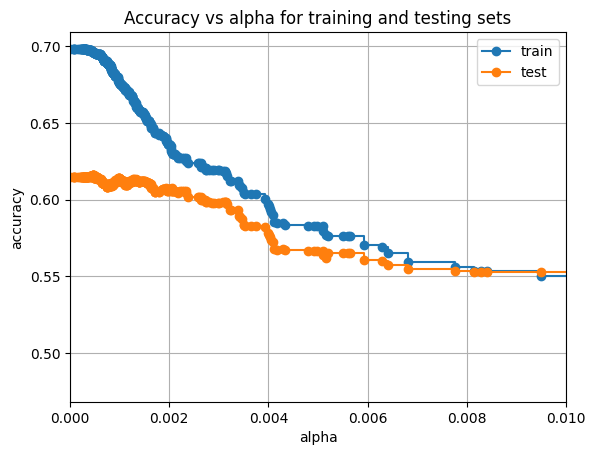

In [156]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.grid()
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.set_xlim(0,0.01)
ax.legend()
plt.show()

We decide to confirm the value of `ccp_alpha` already chosen, that is: `ccp_alpha` = 0.01 .
Note that this numbers come with no uncertainty, so it is not really relevant that test lies slightly over train accuracy. 

What to do now before doing the third map: 
- comments on first map []
- comments on second map []
- in particular, let's see if confusion matrix gives some hints about the choice of the second map []
- searching for some interesting metric of performance in literature []
- start to write report on both maps []